%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install evaluate

In [1]:
import pandas as pd
import datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.nn.parallel import DataParallel
import argparse
import requests
from bs4 import BeautifulSoup, Comment
import numpy as np
from tqdm import tqdm
from transformers import TrainingArguments, Trainer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data = pd.read_csv('./described_dataset_label.csv',sep='\t',encoding='latin-1')
print(f'coumns:{[x for x in data.columns]}')

coumns:['image', 'author', 'title', 'style', 'description']


In [3]:
labels_auth = data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [4]:
data['author'] = data['author'].map(label2id_auth)
data.columns

Index(['image', 'author', 'title', 'style', 'description'], dtype='object')

In [5]:
dataset = datasets.Dataset.from_pandas(data).cast_column('image',datasets.Image())
print(dataset)

Dataset({
    features: ['image', 'author', 'title', 'style', 'description'],
    num_rows: 1083
})


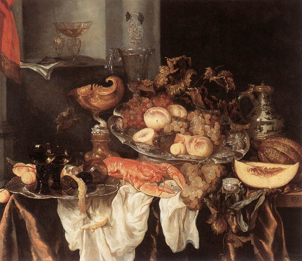

Author: ANGELICO, Fra


In [6]:
sample = dataset[423]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = id2label_auth[sample['author']]
print(f'Author: {author}')

In [7]:
from transformers import AutoProcessor, AutoTokenizer, BlipProcessor
checkpoint_clas = 'google/vit-base-patch16-224-in21k'
checkpoint_capt= "microsoft/git-large-coco"
processor_clas = AutoProcessor.from_pretrained(checkpoint_clas)

In [8]:
#Image Augmentation
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor_clas.image_mean, std=processor_clas.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in processor_clas.size
    else (processor_clas.size["height"], processor_clas.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [9]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [10]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint_clas,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
auth_data = dataset.remove_columns(['style','title','description']).rename_column('author','label')
auth_dataset = auth_data.train_test_split(test_size=0.3)
auth_dataset = auth_dataset.with_transform(transforms)

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [13]:
vit_model_auth = model_clas_auth.to(device)

In [14]:
vit_optimizer_auth = torch.optim.AdamW(vit_model_auth.parameters(), lr=1e-5)
vit_criterion_auth = nn.CrossEntropyLoss()

In [15]:
num_epochs_class = 50
torch.cuda.empty_cache()

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
auth_training_args = TrainingArguments(
    output_dir="test_trainer",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs_class,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)



auth_trainer = Trainer(
    model = vit_model_auth,
    args = auth_training_args,
    data_collator=data_collator,
    train_dataset = auth_dataset['train'],
    eval_dataset = auth_dataset['test'],
    tokenizer = processor_clas,
    compute_metrics = compute_metrics,
)

auth_trainer.train()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,5.030068,0.018462
2,5.021900,4.987905,0.058462
3,5.021900,4.921370,0.181538
4,4.945900,4.802173,0.187692
5,4.748400,4.659754,0.187692
6,4.748400,4.564494,0.187692
7,4.515500,4.498820,0.187692
8,4.515500,4.455933,0.187692
9,4.406300,4.425349,0.187692
10,4.322600,4.402339,0.187692


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=300, training_loss=3.9889658737182616, metrics={'train_runtime': 1066.459, 'train_samples_per_second': 35.538, 'train_steps_per_second': 0.281, 'total_flos': 2.941000136331264e+18, 'train_loss': 3.9889658737182616, 'epoch': 50.0})

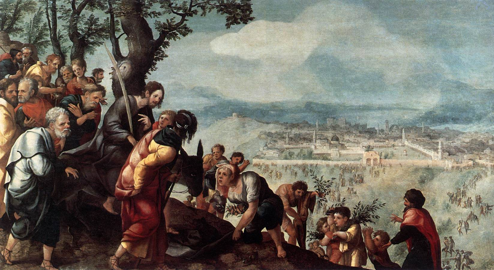

Author: ALBANI, Francesco


In [19]:
sample = dataset[89]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = sample['author']
style = sample['style']
desc = sample['description']
print(f'Author: {id2label_auth[author]}')

In [23]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("test_trainer/checkpoint-300")

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [24]:
predicted_label_auth = logits_auth.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])

ANGELICO, Fra
